In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import iceclassic as ice

## Loading dataset

In [2]:
data=pd.read_csv(filepath_or_buffer='Ice&Temp.csv',index_col=0)
data.index = pd.to_datetime(data.index, format="%Y-%m-%d")
data.info()


data_np=data.dropna().to_numpy()
# converting to numpy drops the index (the date(YYYY/MM/DD))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38578 entries, 1917-01-01 to 2023-04-21
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   IceThickness [cm]              461 non-null    float64
 1   Regional: Air temperature [C]  38563 non-null  float64
 2   Day                            38578 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 1.2 MB


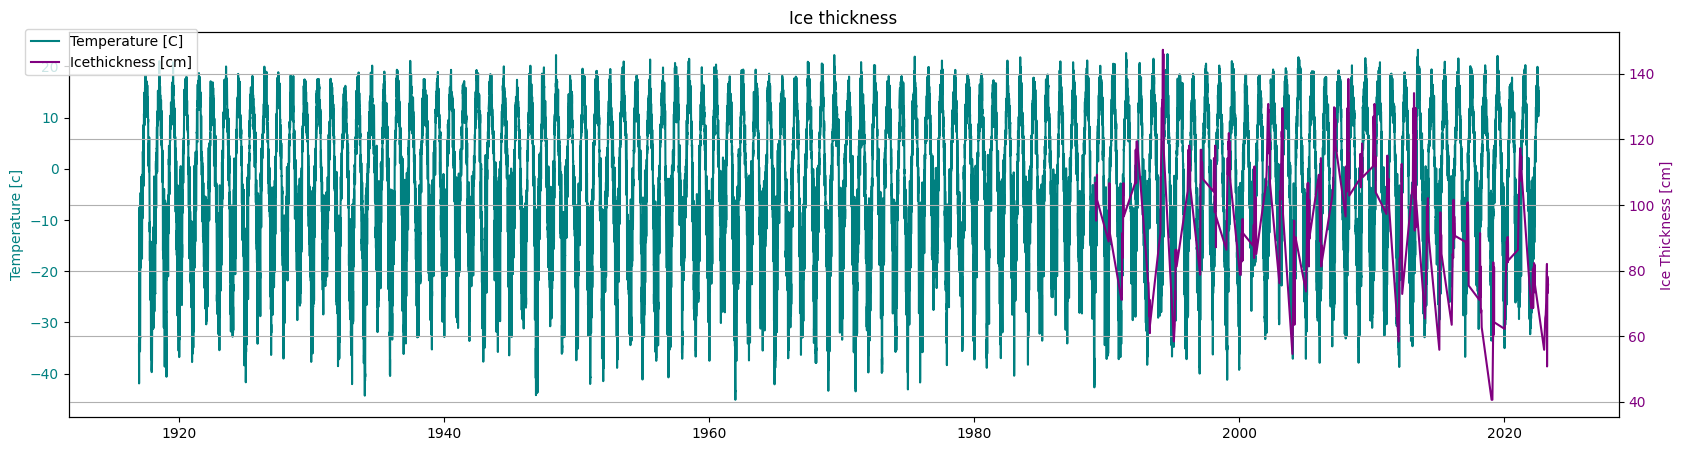

In [3]:
ice=data['IceThickness [cm]'].dropna()
temp=data['Regional: Air temperature [C]'].dropna()

fig, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()
ax1.plot(temp.index, temp, color='teal', label='Temperature [C]')
ax1.set_ylabel('Temperature [c]', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax2.set_title("Ice thickness and Temperature")
ax2.plot(ice.index,ice, color='purple', label='Icethickness [cm]')
ax2.set_xlabel('Date')
ax2.set_ylabel('Ice Thickness [cm]', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.grid()

# ax1.set_xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2018-12-31'))

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

## Changing the function to numpy
The function that computes the finite differences, receives a numpy, first column is the data, second column is the dayofyear column ( to be able to get 'dh' if the observations are not uniformly sampled)

In [4]:
def finite_differences_numpy(arr: np.ndarray,out_type='dataframe'):
    """
    Computes forward, backward, and central differences for a columns in the numpy array.
    
    Parameters
    ----------
    arr : np.ndarray
        Numpy array with columns: ice thickness, temperature, day
    out_type: str
        if the output is array or dataframe ('dataframe' , 'numpy')

    Returns
    -------
    diff_df : pd.DataFrame
        DataFrame with forward, backward, and central differences for ice thickness ( we return df to assign labels and to plot using time)
    """
    
    #This order of column is assumed
    data = arr[:, 0]
    day = arr[:, 1]  

    # Forward difference: (f(x+h) - f(x)) / h
    forward = np.zeros_like(data)
    forward[:-1] = (data[1:] - data[:-1]) / (day[1:] - day[:-1])
    forward[-1] = np.nan  

    # Backward difference: (f(x) - f(x-h)) / h
    backward = np.zeros_like(data)
    backward[1:] = (data[1:] - data[:-1]) / (day[1:] - day[:-1])
    backward[0] = np.nan  

    # Central difference: (f(x+h) - f(x-h)) / (h_forward + h_backward)
    central = np.zeros_like(data)
    central[1:-1] = (data[2:] - data[:-2]) / (day[2:] - day[:-2])
    central[0] = central[-1] = np.nan  #

    if out_type=='dataframe':
        # Create a DataFrame to return the results
        diff_df = pd.DataFrame({
            'forward': forward,
            'backward': backward,
            'central': central
        })
    elif out_type=='numpy':
        diff_df=data

    return diff_df
def plot_gradients(ax:plt.axes,
                    x:pd.Series, 
                    y:pd.Series,
                    slopes:pd.Series,
                    length: int= 2,
                    color: str='blue',
                    label:str=None,
                    label_flag: bool=True,
                    offset: int=0 ):
    """
    Plot gradient slopes and annotate them.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes to plot on.
    x : pd.Series
        The x-values of the data points.
    y : pd.Series
        The y-values of the data points.
    slopes : pd.Series
        The slopes of the data points. Each column column corresponds to a different gradient type.
    length : int, optional
        The length of the gradient line. Default is 2.
    color : str, optional   
        The color of the gradient line. Default is 'blue'.
    label : str, optional
        The label of the gradient line. Default is None.
    label_flag : bool, optional
        Whether to show the label. Default is True.
    offset : int, optional
        The offset of the annotation. Default is 0. Use to avoid overlapping annotations.

    Returns
    -------
    annotations : list
        A list of annotations of the value of the gradient at each point, using all the graudient types.
    """
    #
    # (annotations)code shamelessly stolen from chatgpt 
    annotations = []
    for i in range(len(x)):
        if np.isnan(slopes.iloc[i]):
            continue  
        dx = length  
        dy = slopes.iloc[i] * dx  
        
        ax.plot(
            [x[i], x[i] + pd.Timedelta(days=dx)], 
            [y.iloc[i], y.iloc[i] + dy], 
            color=color, alpha=0.7, label=label if label_flag else ""
        )
        
        annotations.append({
            'x': x[i] + pd.Timedelta(days=dx / 2),
            'y': y.iloc[i] + offset,
            'text': f'{slopes.iloc[i]:.2f}',
            'color': color
        })
        label_flag = False  #


    for annotation in annotations:
        ax.annotate(
            annotation['text'], 
            (annotation['x'], annotation['y']), 
            color=annotation['color'], fontsize=10, ha='center'
        )
def plot_gradients_and_timeseries(result:pd.DataFrame,
                                 col:pd.Series, 
                                 year:int, 
                                 plot_gradient_as_slope:bool=False,
                                 Title: str=None ,
                                 ylabel: str=None,
                                 xlim: list=['01/01', '12/31'],
                                 ylim: list=None,
                                 annotation_offsets: dict= {'forward': -3, 'backward': -6, 'central': -9},
                                 vline: dict=None):
    """
    Plots ice thickness gradients and ice thickness for a selected year.

    Parameters
    ----------
    result: pd.DataFrame
        DataFrame containing the gradients with columns ['forward', 'backward', 'central'].
    col: pd.Series
         Series containing the columns values indexed by datetime.
    year: int
        The year to filter and plot data for.
    plot_gradient_as_slope: bool
        If True, plots lines with gradients and annotations.
    Title: str
        title of the plot
    ylabel: str
        ylabel of the plot
    ylim: list
        y-axis limits for the plot. List should be in the format [(MM/DD),(MM/DD)].
    annotation_offsets: dict
        The offset of the annotation. Default value assume that the series has three column corresponding to 
        forward, backward and central. Use to avoid overlapping annotations. The value corresponds to the y-axis value.

        
    Returns
    -------
    plt.figure
    """
    
    result_year = result[result.index.year == year]
    col_year = col[col.index.year == year]

    xlimits=pd.to_datetime([str(year) + '/' + e for e in xlim])

    
    if not plot_gradient_as_slope:
        fig, ax1 = plt.subplots(figsize=(20, 5))

        ax1.plot(result_year['forward'], label='Forward', color='red')
        ax1.plot(result_year['backward'], label='Backward', color='green')
        ax1.plot(result_year['central'], label='Central', color='blue')

        ax1.set_ylabel(ylabel)
        ax1.set_xlabel('Date')
        ax1.set_title(Title)
        ax1.grid()


        ax1.set_xlim(xlimits)
        ax1.set_ylim(ylim)
	

      
        #ax1.set_xlim(result_year.index.min(), result_year.index.max())
        ax1.legend(loc='upper left')

      
        ax2 = ax1.twinx()
        ax2.scatter(col_year.index, col_year, color='black', alpha=0.4, label='data')
        ax2.plot(col_year.index, col_year, color='black', alpha=0.4)
        

       
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')

        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(20, 5))

        ax.plot(col_year.index, col_year, label='Thickness', color='black', linestyle='--', alpha=0.4)
        ax.scatter(col_year.index, col_year, color='black', alpha=0.4)

      
        offsets = annotation_offsets
        
        for grad_type, color in zip(['forward', 'backward', 'central'], ['red', 'green', 'blue']):
            slopes = result_year[grad_type]
            plot_gradients(ax, result_year.index, col_year, slopes, color=color, label=grad_type.capitalize(), label_flag=True, offset=offsets[grad_type])

        ax.set_title(Title)
        ax.set_xlabel('Date')
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlimits)
        ax.set_ylim(ylim)
        ax.grid(True)
        
        ax.legend()
        plt.show()

if we use numpy we lose the datetime index, because the sampling is not constant, the x vector (indexes) does not mean anything, cuz they do not represent equidistant dates. So we would need to reconstruct the xvector with dates.

Also, specially in the ice thickness with more than 6 months without observations, the gradient between the end of winter and mid-fall  do not represent anything in reality, this carry over from one year to another can be treated individually in numpy by simply deleting the data for that index

      forward  backward   central
0   -0.635000       NaN       NaN
1    0.000000 -0.635000 -0.496957
2    1.905000  0.000000  0.846667
3    0.846667  1.905000  1.451429
4    0.181429  0.846667  0.381000
..        ...       ...       ...
441  1.238250 -0.889000  0.326571
442 -4.191000  1.238250 -0.571500
443  1.574800 -4.191000 -0.072571
444 -1.778000  1.574800  0.317500
445       NaN -1.778000       NaN

[446 rows x 3 columns]
      forward  backward   central
0   -0.056783       NaN       NaN
1   -0.529962 -0.056783 -0.159648
2    0.997851 -0.529962  0.149066
3   -2.422825  0.997851 -0.468153
4    1.130341 -2.422825  0.064391
..        ...       ...       ...
441 -0.296350  2.948606  1.094346
442  1.971653 -0.296350  0.459651
443 -0.521064  1.971653  0.191140
444  0.832550 -0.521064 -0.013459
445       NaN  0.832550       NaN

[446 rows x 3 columns]


Text(0.5, 0, 'Index')

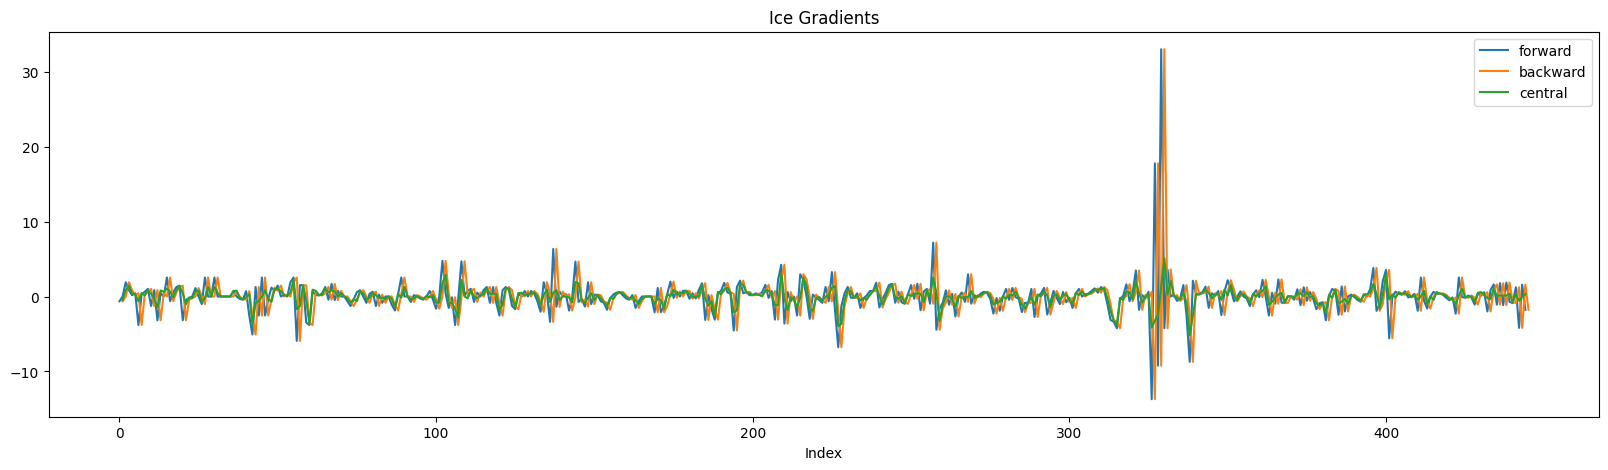

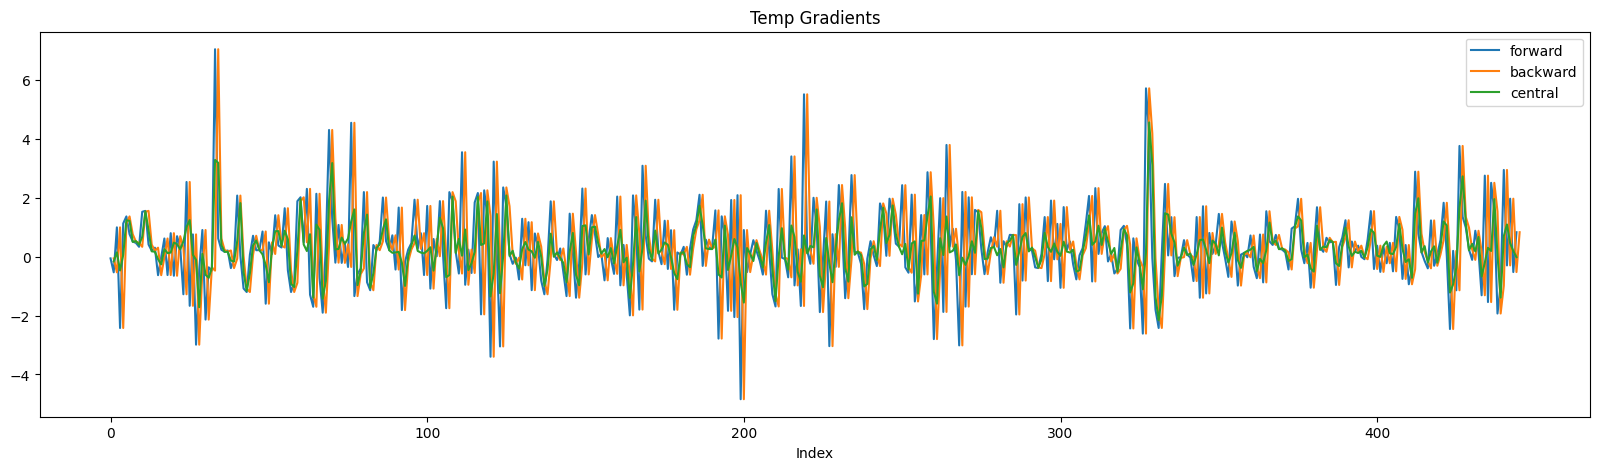

In [5]:

grad_ice = finite_differences_numpy(arr=data_np[:,[0,2]])
print(grad_ice)

plt.figure(figsize=(20, 5))  
for col in grad_ice.columns:
    plt.plot(grad_ice[col].dropna(), label=col)

plt.title('Ice Gradients')
plt.legend()
plt.xlabel('Index')






grad_temp = finite_differences_numpy(arr=data_np[:,[1,2]]) # see function to understand why we pass this columns 
print(grad_temp)

plt.figure(figsize=(20, 5))  
for col in grad_temp.columns:
    plt.plot(grad_temp[col].dropna(), label=col)

plt.title('Temp Gradients')
plt.legend()
plt.xlabel('Index')

if we want to fix the issue of gradient carrying over from one year to another and add the date associated with every observation, we trasnfromt to df, group the data into years and apply the function to each year in one go.

But if we care only about the values, or use a column evenly sampled ( like temp), with numpy we could easily reconstruct the time vector to plot.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 461 entries, 1989-02-26 to 2023-04-21
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   forward   426 non-null    float64
 1   backward  426 non-null    float64
 2   central   391 non-null    float64
dtypes: float64(3)
memory usage: 14.4 KB
None


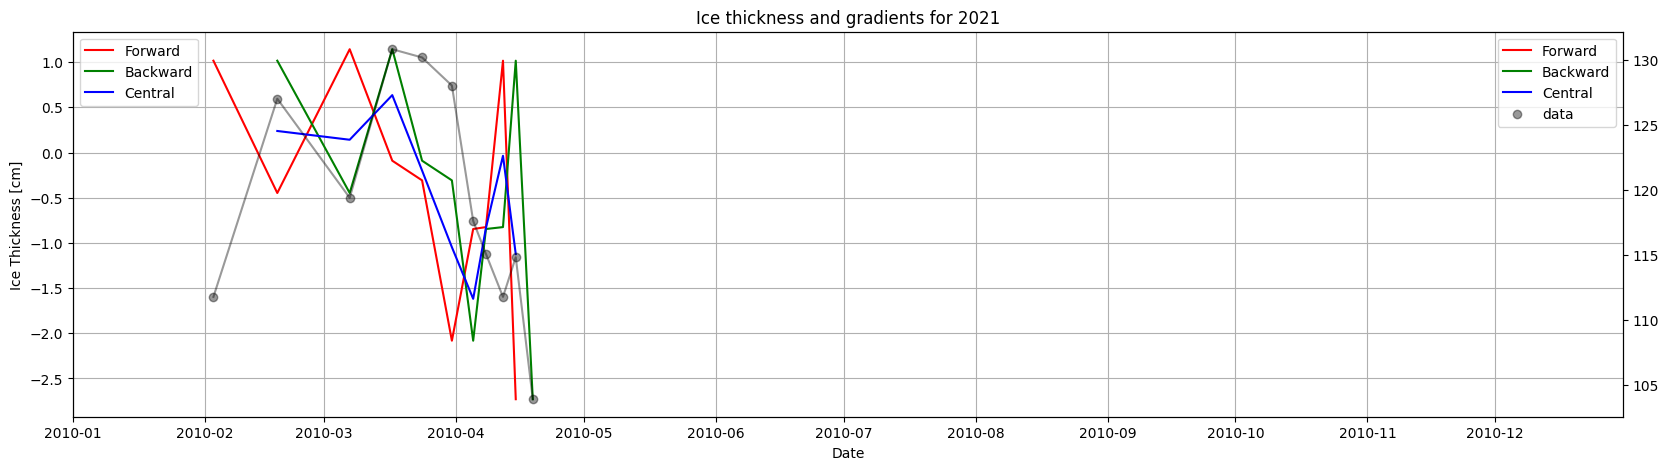

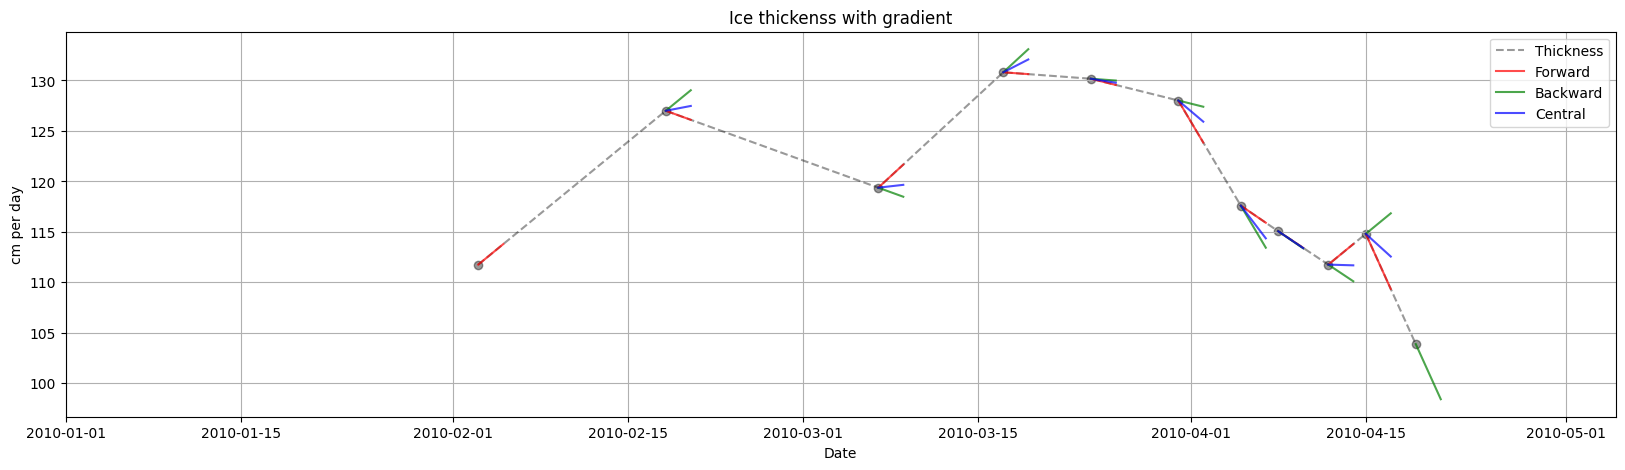

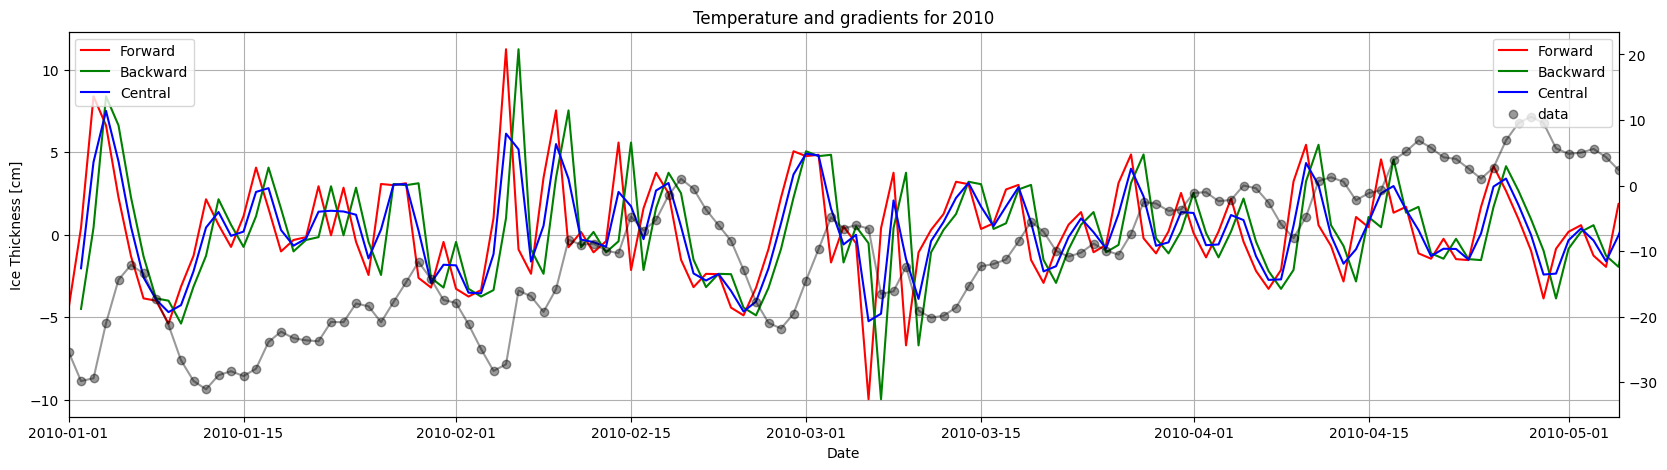

c:\Users\gabri\anaconda3\envs\ice_package_test\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


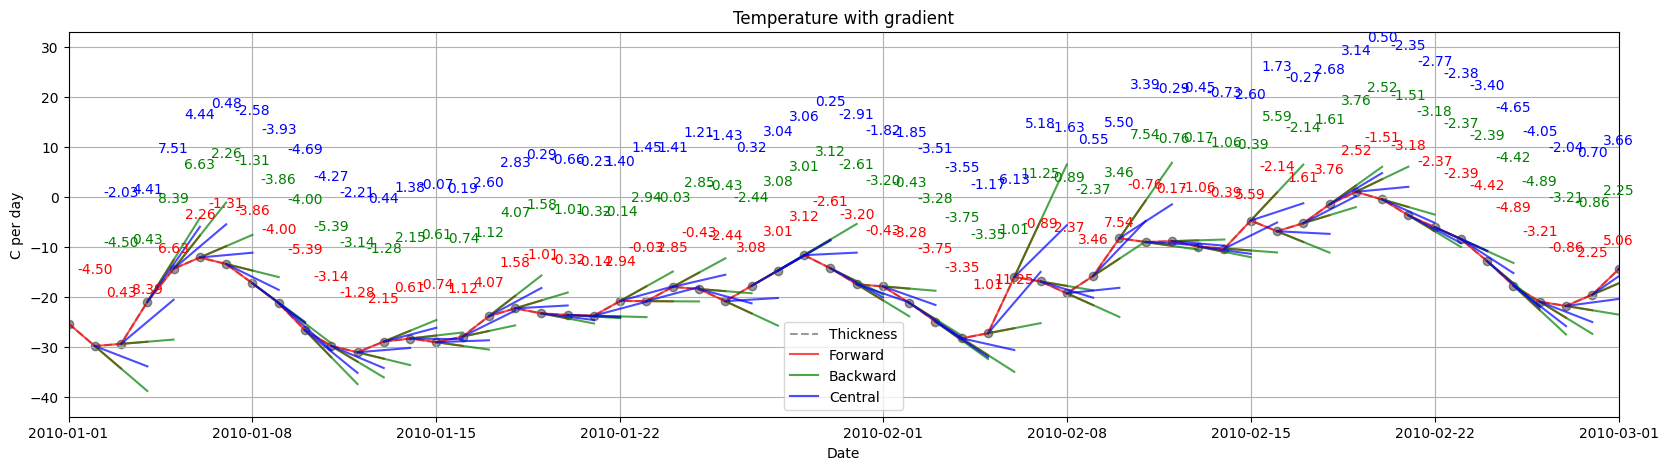

In [12]:
# suffle indexes around to match the function that we had before ( mixing df and numpy is not ideal, and becasue we already have the function with the nice plots in df, i decide to just adapt it)

ice = data[['IceThickness [cm]', 'Day']].dropna(subset=['IceThickness [cm]'])
result_ice = ice.groupby(ice.index.year, group_keys=True).apply(
    lambda group: finite_differences_numpy(group[['IceThickness [cm]', 'Day']].values)
).reset_index(level=0, drop=True)
result_ice.index = ice.index[ice['IceThickness [cm]'].notna()]


print(result_ice.info())

plot_gradients_and_timeseries(result_ice, 
                             data['IceThickness [cm]'].dropna(),
                            2010,
                            Title='Ice thickness and gradients for 2021',
                            ylabel='Ice Thickness [cm]')


plot_gradients_and_timeseries(result_ice,
                           data['IceThickness [cm]'].dropna(),
                            2010,
                            plot_gradient_as_slope=True,
                            xlim=['01/01', '05/05'],
                            Title='Ice thickenss with gradient',
                            ylabel='cm per day',
                            annotation_offsets={'forward': 100, 'backward': 200, 'central': 300})


temp = data[['Regional: Air temperature [C]', 'Day']].dropna(subset=["Regional: Air temperature [C]"])
result_temp = temp.groupby(temp.index.year, group_keys=True).apply(
    lambda group: finite_differences_numpy(group[['Regional: Air temperature [C]', 'Day']].values)
).reset_index(level=0, drop=True)
result_temp.index = temp.index[temp['Regional: Air temperature [C]'].notna()]


plot_gradients_and_timeseries(result_temp, 
                             data['Regional: Air temperature [C]'].dropna(),
                            2010,
                            Title='Temperature and gradients for 2010',
                            ylabel='Ice Thickness [cm]',
                            xlim=['01/01', '05/05'])


plot_gradients_and_timeseries(result_temp,
                           data['Regional: Air temperature [C]'].dropna(),
                            2010,
                            plot_gradient_as_slope=True,
                            xlim=['01/01', '03/01'],
                            Title='Temperature with gradient',
                            ylabel='C per day',
                            annotation_offsets={'forward': 10, 'backward': 20, 'central': 30})
